#### Importing Required Libraries

In [37]:
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#from sklearn import preprocessing

#### Creating Lists to store the plagiarism rates

In [38]:
Jaccard=[[],[],[],[]]
Containment=[[],[],[],[]]
TFIDF=[[],[],[],[]]
LCS=[[],[],[],[]]

#### Reading CSV File 

In [39]:
df = pd.read_excel("corpus-final091.xlsx")
#df['Category'].unique()

## Code for all Four Models

In [40]:
for z in range(0,len(df)):
    #print(df['Category'][z])
    #print(df['File'][i])
    #--------------------------------------------------------------------------------
    #Opening Plagiarised file as plag
    with open(df['File'][z], "r" , encoding="unicode_escape") as f1:
        plag=f1.read().replace("\n"," ")
        f1.close()
        
    #--------------------------------------------------------------------------------
    #Opening Original File as orig
        if(df['Task'][z]=='a'):
            OrifFile='orig_taska.txt' #Creating a Variable for Original File Name
        elif(df['Task'][z]=='b'):
            OrifFile='orig_taskb.txt'
        elif(df['Task'][z]=='c'):
            OrifFile='orig_taskc.txt'
        elif(df['Task'][z]=='d'):
            OrifFile='orig_taskd.txt'
        elif(df['Task'][z]=='e'):
            OrifFile='orig_taske.txt'
        with open(OrifFile, "r" , encoding="unicode_escape") as f2:
            orig=f2.read().replace("\n"," ")
            f2.close()
            
    #-----------------------------------------------------------------------------------------
        #word tokenisation
        tokens_o=word_tokenize(orig)
        tokens_p=word_tokenize(plag)
    #------------------------------------------------------------------------------------------
        #lowerCase
        tokens_o = [token.lower() for token in tokens_o]
        tokens_p = [token.lower() for token in tokens_p]
        #print(len(tokens_o), len(tokens_p))
    #-------------------------------------------------------------------------------------------
        #stop word removal
        #punctuation removal
        stop_words=set(stopwords.words('english'))
        punctuations=['"','.','(',')',',','?',';',':',"''",'``']
        filtered_tokens_o = [w for w in tokens_o if not w in stop_words and not w in punctuations]
        filtered_tokens_p = [w for w in tokens_p if not w in stop_words and not w in punctuations]
        #print(len(filtered_tokens_o),len(filtered_tokens_p))
        
    #----------------------------------------------------------------------------------------------
        #Trigram Similiarity measures
        trigrams_o=[]
        for i in range(len(filtered_tokens_o)-2):
            t=(filtered_tokens_o[i],filtered_tokens_o[i+1],filtered_tokens_o[i+2])
            #print(t)
            trigrams_o.append(t)

        s=0
        trigrams_p=[]
        for i in range(len(filtered_tokens_p)-2):
            t=(filtered_tokens_p[i],filtered_tokens_p[i+1],filtered_tokens_p[i+2])
            trigrams_p.append(t)
            if t in trigrams_o:
                s+=1

        #jaccord coefficient = (S(o)^S(p))/(S(o) U S(p))
        J=s/(len(trigrams_o)+len(trigrams_p))
        #print(J)

        #containment measure
        C=s/len(trigrams_p)
        #print(C)
        
        #-----------------------------------------------------------------------------------------------------------------#
        #dynamic programming algorithm for finding lcs
        def lcs(l1,l2):
            s1=word_tokenize(l1)
            s2=word_tokenize(l2)
            # storing the dp values 
            dp = [[None]*(len(s1)+1) for i in range(len(s2)+1)] 

            for i in range(len(s2)+1): 
                for j in range(len(s1)+1): 
                    if i == 0 or j == 0: 
                        dp[i][j] = 0
                    elif s2[i-1] == s1[j-1]: 
                        dp[i][j] = dp[i-1][j-1]+1
                    else: 
                        dp[i][j] = max(dp[i-1][j] , dp[i][j-1]) 
            #print(i,j,len(dp[0]),len(dp))
            return dp[len(s2)][len(s1)] 
        
        sent_o=sent_tokenize(orig)
        sent_p=sent_tokenize(plag)

        #maximum length of LCS for a sentence in suspicious text
        max_lcs=0
        sum_lcs=0

        for i in sent_p:
            for j in sent_o:
                l=lcs(i,j)
                max_lcs=max(max_lcs,l)
            sum_lcs+=max_lcs
            max_lcs=0

        score=sum_lcs/len(tokens_p)
        #print(score)
        
        #---------------------------------------------------------------------------------------------------------#
        #TF-TDF Method
        word_set=set(filtered_tokens_o).union(set(filtered_tokens_p))
        
        #TF For each word in original Document
        freqd_orig=FreqDist(filtered_tokens_o)
        filtered_tokens_o_len=len(filtered_tokens_o)
        org_tf_dict=dict.fromkeys(word_set,0)
        for word in filtered_tokens_o:
            org_tf_dict[word]=freqd_orig[word]/filtered_tokens_o_len
        #print(org_tf_dict)
        
        #TF For each word in Plagiarised Document
        freqd_plag=FreqDist(filtered_tokens_p)
        filtered_tokens_p_len=len(filtered_tokens_p)
        plag_tf_dict=dict.fromkeys(word_set,0)
        for word in filtered_tokens_p:
            plag_tf_dict[word]=freqd_plag[word]/filtered_tokens_p_len
        
        #IDF For all the words in both the texts
        op_idf_dict=dict.fromkeys(word_set,0)
        op_length=2 # for 2 documents
        for word in op_idf_dict.keys():
            if word in filtered_tokens_o:
                op_idf_dict[word]+=1
            if word in filtered_tokens_p:
                op_idf_dict[word]+=1
        #print(op_idf_dict)

        for word, val in op_idf_dict.items():
            op_idf_dict[word]=1+math.log(op_length/(float(val)))
        #print(op_idf_dict)   
        
        #TF-IDF For words in Original Document
        #Formula - TFIDF of a word = (TF of the word) * (IDF of the word)
        org_tfidf_dict=dict.fromkeys(word_set,0)
        for word in filtered_tokens_o:
            org_tfidf_dict[word]=(org_tf_dict[word])*(op_idf_dict[word])
            
        #TF-IDF For words in Plagiarised Document    
        plag_tfidf_dict=dict.fromkeys(word_set,0)
        for word in filtered_tokens_p:
            plag_tfidf_dict[word]=(plag_tf_dict[word])*(op_idf_dict[word])
        
        #Distance Computation using Cosine Similarity
        v1=list(org_tfidf_dict.values())
        v2=list(plag_tfidf_dict.values())
        similarity=1-nltk.cluster.cosine_distance(v1,v2)
        #print(similarity)
        
        #---------------------------------------------------------------------------------------------------------#
        #Appending the Computed scores in respective Lists
        if(df['Category'][z]=='non'):
            index=0
        elif(df['Category'][z]=='heavy'):
            index=1
        elif(df['Category'][z]=='light'):
            index=2
        elif(df['Category'][z]=='cut'):
            index=3
        
        Jaccard[index].append(J)
        Containment[index].append(C)
        LCS[index].append(score)
        TFIDF[index].append(similarity)
        


In [44]:
LCS[3]

[0.9702127659574468,
 0.5870786516853933,
 0.8787878787878788,
 0.8038277511961722,
 1.0,
 0.43333333333333335,
 0.622478386167147,
 0.501628664495114,
 0.5,
 0.9153094462540716,
 0.7383966244725738,
 0.22142857142857142,
 0.8287292817679558,
 0.9808917197452229,
 0.9936708860759493,
 0.9485861182519281,
 0.9734513274336283,
 0.2878228782287823,
 0.4430379746835443]

#### Aggregating Values inside each list

In [32]:
for i in range(len(LCS)):
    Jaccard[i]=sum(Jaccard[i])/len(Jaccard[i])
    Containment[i]=sum(Containment[i])/len(Containment[i])
    LCS[i]=sum(LCS[i])/len(LCS[i])
    TFIDF[i]=sum(TFIDF[i])/len(TFIDF[i])

#### Final Computed scores for all four types using 4 Methods

In [33]:
for i in range(len(LCS)):
    print(Jaccard[i],Containment[i],LCS[i],TFIDF[i])

0.0034098556832884794 0.010439228443544607 0.25991819887536505 0.20995229579432478
0.08668813887367204 0.22751146470804784 0.4807377624057654 0.5147808093224974
0.15554086207625226 0.4256772231264582 0.682261543194217 0.5802669831164222
0.21733335136640572 0.6076285523595406 0.7172985399981427 0.5534912796409263


#### Plotting the Results

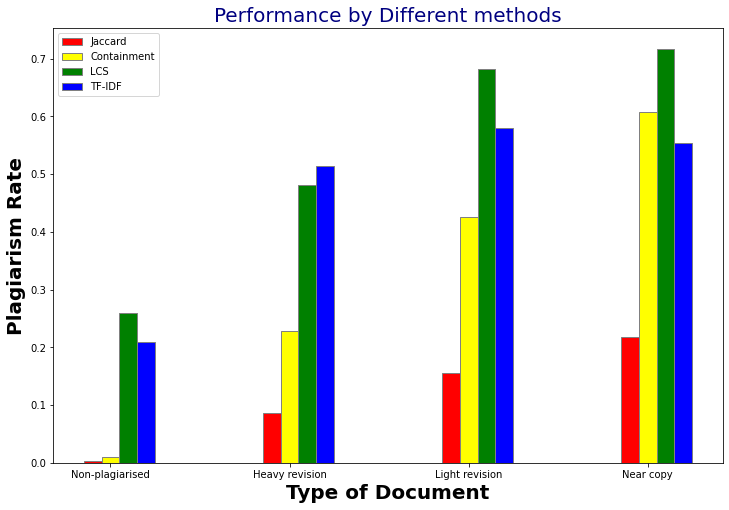

In [34]:
# set width of bar
barWidth = 0.1
fig = plt.subplots(figsize =(12, 8))
br1 = np.arange(len(LCS))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
 
# Make the plot
plt.bar(br1, Jaccard, color ='Red', width = barWidth,
        edgecolor ='grey', label ='Jaccard')
plt.bar(br2, Containment, color ='yellow', width = barWidth,
        edgecolor ='grey', label ='Containment')
plt.bar(br3, LCS, color ='g', width = barWidth,
        edgecolor ='grey', label ='LCS')
plt.bar(br4, TFIDF, color ='b', width = barWidth,
        edgecolor ='grey', label ='TF-IDF')

 
# Adding Xticks
plt.xlabel('Type of Document', fontweight ='bold', fontsize = 20)
plt.ylabel('Plagiarism Rate', fontweight ='bold', fontsize = 20)
plt.xticks([r + barWidth for r in range(len(LCS))],
        ['Non-plagiarised', 'Heavy revision', 'Light revision','Near copy'])
plt.title("Performance by Different methods", color='navy',fontsize = 20)
 
plt.legend()
plt.show()